In [3]:
#======================================================================#
#                   EJEMPLO 2 (DOMINIO RECTANGULAR)                    #
#                                                                      #
#   Este programa resuelve la ecuación de Laplace:                     #
#                          u_{xx} + u_{yy} = 0,                        #
#   con condiciones de frontera mixtas:                                #
#     - Condición de Neumann en el borde izquierdo                     #
#     - Condiciones de Dirichlet en los demás bordes                   #
#                                                                      #
#   La solución exacta está dada por:                                  #
#     u(x,y) = sin(pi*x)*sin(pi*y)                                     #
#                                                                      #
#----------------------------------------------------------------------#

#----------------------------------------------------------------------#
# Importación de bibliotecas necesarias para el modelo
#----------------------------------------------------------------------#

#-----------------
import numpy as np                               # Operaciones numéricas con arreglos
import matplotlib.pyplot as plt
from scipy.interpolate import griddata           # Interpolación para mapeo en una malla
import time                                      # Para medir tiempos de ejecución
#----------------------------------------------------------------------#

# Geometry and grid
import pygmsh
import meshio
#----------------------------------------------------------------------#

# External code
from PINN_2D_Neuman import PhysicsInformedNN

## Circle: colocation and boundry pts, clasification

In [3]:
# Parametrization of the circle (boundry)
R = 2.0                                   # Radious
theta = np.random.uniform(0, 2*np.pi, 30) # Angle

# Transformation to polar coordenates
def polar(r, theta):
  return np.array([r*np.cos(theta), r*np.sin(theta)]).T

# Normal coordenates in points
def N_circ(R, X): # X is the coordenates vector
    return (1/R)*X/np.sqrt(np.sum(X**2))

In [4]:
# Separation of angles
theta_u = theta[theta < np.pi]
theta_un = theta[theta >= np.pi]

# coordenates of bdy points
X_u = polar(R, theta_u)
X_un = polar(R, theta_un)

# Normal vectors
dX_un = N_circ(R, X_un)

In [5]:
N_u, N_un = len(X_u), len(X_un)
N_u, N_un

(14, 16)

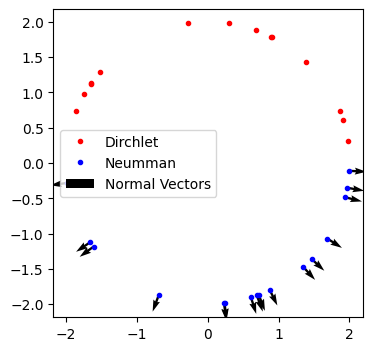

In [6]:
plt.figure(figsize = (4,4))
plt.plot(X_u[:,0], X_u[:,1], '.r', label = 'Dirchlet')
plt.plot(X_un[:,0], X_un[:,1], '.b', label = 'Neumman')

# Vectores normales
plt.quiver(X_un[:,0], X_un[:,1], dX_un[:,0], dX_un[:,1], label = 'Normal Vectors')

plt.legend()
plt.show()

### Determinar valores de la condición de Neumann

In [8]:
def u(x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def grad_u(x,y): # Gradiente
    return np.array([ np.pi*np.cos(np.pi*x)*np.sin(np.pi*y), np.pi*np.sin(np.pi*x)*np.cos(np.pi*y)  ])

Para calcular las constantes para las condiciones de Neumann sabemos que 
$$ \frac{\partial u}{\partial n} = \nabla u \cdot n $$

Por lo tanto, dada la solución analítica y las coordenadas de los vectores normales, podemos calcular las condiciones de la siguiente manera.

In [10]:
grad_un = grad_u(X_un[:,0], X_un[:,1]).T # Los gradientes en cada punto de la función

un_train = []

for grad, dX in zip(grad_un, dX_un):
    un_train.append(np.dot(grad, dX))

np.array([un_train]).T # Constantes de Neumann

array([[-0.30956613],
       [-0.25745202],
       [ 0.29781579],
       [-0.34008434],
       [ 0.12337125],
       [-0.29472441],
       [-0.13977825],
       [-0.26262393],
       [-0.20257305],
       [-0.37304542],
       [-0.12884288],
       [-0.14047484],
       [ 0.12327743],
       [-0.13300433],
       [ 0.30922254],
       [-0.34811275]])

### Condiciones de Dircihlet y rhs

In [12]:
u_train = np.array([u(X_u[:,0], X_u[:,1])]).T

#### Verificadores

## PINNs implementation

# Rutine and training

In [5]:
if __name__ == "__main__":

    N_bdy = 40     # Cantidad de puntos en la frontera
    N_int  = 200   # Puntos de colocación en el dominio

    # .----------------------------------------------.
    # |              MALLA DEL DOMINIO               |
    # .______________________________________________.

    # ===========================================================
    # 1. Parámetros del círculo
    # ===========================================================
    R = 1.0       # radio
    lc = 0.1      # tamaño característico

    # ===========================================================
    # 2. Geometría con API moderna de pygmsh
    # ===========================================================
    with pygmsh.geo.Geometry() as geom:
        # Crear un círculo (curva cerrada)
        circle = geom.add_circle([0.0, 0.0, 0.0], R, mesh_size=lc)

        # Crear la superficie delimitada por ese círculo
        plane_surface = geom.add_plane_surface(circle.curve_loop)

        # Etiquetas físicas
        geom.add_physical(circle.curve_loop.curves, label="Frontera")
        geom.add_physical(plane_surface, label="Interior")

        # Generar malla
        mesh = geom.generate_mesh()

    # ===========================================================
    # 3. Extraer datos
    # ===========================================================
    points = mesh.points[:, :2]
    cells  = mesh.get_cells_type("triangle")

    # ===========================================================
    # 4. Clasificar nodos frontera/interior
    # ===========================================================
    tol = 1e-3
    radii = np.sqrt(points[:,0]**2 + points[:,1]**2)
    boundary_nodes = np.where(np.abs(radii - R) < tol)[0]
    interior_nodes = np.where(radii < R - tol)[0]

    xp = points[:,0]
    yp = points[:,1]
    
    Xp_star = points

    # .----------------------------------------------.
    # |       SOLUCIÓN EXACTA ANALÍTICA              |
    # .______________________________________________.

    """
        Define the eq to solve: analytical:

        u_train: bdy sol values
    """

    def u(X):
        return np.sin(np.pi*X[:,0])*np.sin(np.pi*X[:,1])

    up_star = u(points)

    # .-------------------------------------------------.
    # | Frontera: VECTORES NORMALES Y DERIVADAS NEUMANN |
    # ._________________________________________________.

    # Parametrization of the circle (boundry)
    theta = np.random.uniform(0, 2*np.pi, N_bdy) # Angle sample

    # Transformation to polar coordenates
    def polar(r, theta):
        return np.array([r*np.cos(theta), r*np.sin(theta)]).T

    # Normal coordenates in points
    def N_circ(R, X): # X is the coordenates vector
        return (1/R)*X/np.sqrt(np.sum(X**2))

    # Separation of angles
    theta_u = theta[theta < np.pi]
    theta_un = theta[theta >= np.pi]

    # Coordenates of bdy points
    X_u_train = polar(R, theta_u)
    X_un_train = polar(R, theta_un)

    # Number of types of bc
    N_u, N_un = len(X_u_train), len(X_un_train)

    # Normal vectors
    dX_un = N_circ(R, X_un_train)

    # Joint of (x,y) with (nx, ny)

    X_un_train = np.hstack([X_un_train, dX_un])

    # Defiying Neumann conditions

    # Gradient function
    def grad_u(X): # Gradiente
        return np.array([ np.pi*np.cos(np.pi*X[:,0])*np.sin(np.pi*X[:,1]), np.pi*np.sin(np.pi*X[:,0])*np.cos(np.pi*X[:,1])  ]).T

    # Calculate gradient
    grad_un = grad_u(X_un_train)

    # Calculate the conditions
    un_train = []

    for grad, dX in zip(grad_un, dX_un):
        un_train.append(np.dot(grad, dX)) #Gradient(x,y) . normal(x,y)

    un_train = np.array([un_train]).T

    # Calculate Dirchlet conditions
    u_train = np.array([u(X_u_train)]).T
    
    # .----------------------------------------------.
    # |   PUNTOS DE ENTRENAMIENTO Y COLOCACIÓN       |
    # .______________________________________________.

    # [0] Puntos de frontera para entrenamiento
    # Uniform sampling (2D)
    theta_sample = np.random.uniform(0, 2*np.pi, N_int)
    r_sample = R * np.sqrt(np.random.uniform(0, 1, N_int)) # R\sqrt{U}

    X_f_train = polar(r_sample, theta_sample)

    # Fount term
    def rhs(X):
    	return np.array([-(2*np.pi**2)*np.sin(np.pi*X[:,0])*np.sin(np.pi*X[:,1])]).T

    rhs_train = rhs(X_f_train)

In [43]:
if __name__ == "__main__":

    # .================================================================.
    # | [S.1]                    PREPARACIÓN                           |
    # .================================================================.

    # .----------------------------------------------.
    # |                 PARÁMETROS                   |
    # .______________________________________________.

    #-------------------------------

    Ne     = 30                    # Número de neuronas por capa oculta
    layers = [2, Ne, Ne, Ne, Ne, 1]    # Arquitectura de la red

    epochs = 10000
    lr = 1e-3

    #-------------------------------
    # Mostrar resumen de parámetros en consola
    print('  ')
    print('---------------------------------------------')
    print('              PROBLEMA ELÍPTICO              ')
    print('---------------------------------------------')
    print('  ENTRENAMIENTO:                             ')
    print('  Puntos de frontera (Dirichlet y Nuemman)  N_u  =',N_bdy)
    print('  Puntos internos (colocación)              N_f  =',N_int)
    print('---------------------------------------------')
    print('  RED NEURONAL:                              ')
    print('  Arquitectura de capas =', layers)
    print('---------------------------------------------')



    # .================================================================.
    # | [S.2]                    APROXIMACIÓN                          |
    # .================================================================.

    # .----------------------------------------------.
    # |          ENTRENAMIENTO DEL MODELO            |
    # .______________________________________________.

    #  Construcción de la red neuronal con condiciones físicas
    model = PhysicsInformedNN(X_u_train, u_train,
                              X_un_train, un_train,
                              X_f_train, rhs_train,
                              layers, epochs, lr, True)

    # Entrenamiento de la red neuronal
    start_time = time.time()
    model.train()
    elapsed = time.time() - start_time

    # .----------------------------------------------.
    # |           PREDICCIÓN DE LA SOLUCIÓN          |
    # .______________________________________________.

    up_pred = model.predict(Xp_star)   # un solo vector de predicciones

    # Error absoluto punto a punto
    Errorp = np.abs(up_star - up_pred)

    # .----------------------------------------------.
    # |       CÁLCULO DE ERRORES: NORMA L2 Y MAX     |
    # .______________________________________________.

    error_u   = np.linalg.norm(up_star - up_pred[:,0], 2) / np.linalg.norm(up_star, 2)
    error_max = np.linalg.norm(up_star - up_pred[:,0], np.inf)

    # .================================================================.
    # | [S.3]                    RESULTADOS                            |
    # .================================================================.

    print('---------------------------------------------')
    print('  ENTRENAMIENTO:                             ')
    print('  Dirichlet  N_u  =', N_u)
    print('  Neumann    N_un =', N_un)
    print('  Colocación N_f  =', N_int)
    print('---------------------------------------------')
    print('  RED NEURONAL:                              ')
    print('  Arquitectura de capas =', layers)
    print('---------------------------------------------')
    print('  N_un   N_u    N_f    ||·||_L2      ||·||_∞')
    print('  %3s    %3s   %3s   %e    %e' % (N_un, N_u, N_int, error_u, error_max))
    print('---------------------------------------------')
    print('  Tiempo de entrenamiento: %.4f seg' % elapsed)
    print('---------------------------------------------\n')


  
---------------------------------------------
              PROBLEMA ELÍPTICO              
---------------------------------------------
  ENTRENAMIENTO:                             
  Puntos de frontera (Dirichlet y Nuemman)  N_u  = 40
  Puntos internos (colocación)              N_f  = 200
---------------------------------------------
  RED NEURONAL:                              
  Arquitectura de capas = [2, 30, 30, 30, 30, 1]
---------------------------------------------
Epoch 0, Loss: 1.17769e+02,  U_loss: 3.67863e-01, Un_loss: 2.10296e-01, f_loss: 1.17191e+02
Epoch 100, Loss: 1.19170e+01,  U_loss: 8.69527e-01, Un_loss: 2.33752e-01, f_loss: 1.08137e+01
Epoch 200, Loss: 1.07538e+00,  U_loss: 3.86421e-01, Un_loss: 2.39898e-01, f_loss: 4.49062e-01
Epoch 300, Loss: 7.23012e-01,  U_loss: 2.74025e-01, Un_loss: 2.25759e-01, f_loss: 2.23229e-01
Epoch 400, Loss: 5.24148e-01,  U_loss: 1.90386e-01, Un_loss: 2.08939e-01, f_loss: 1.24823e-01
Epoch 500, Loss: 4.01324e-01,  U_loss: 1.36707e-0

# Gráficas

Gráfica para los grids

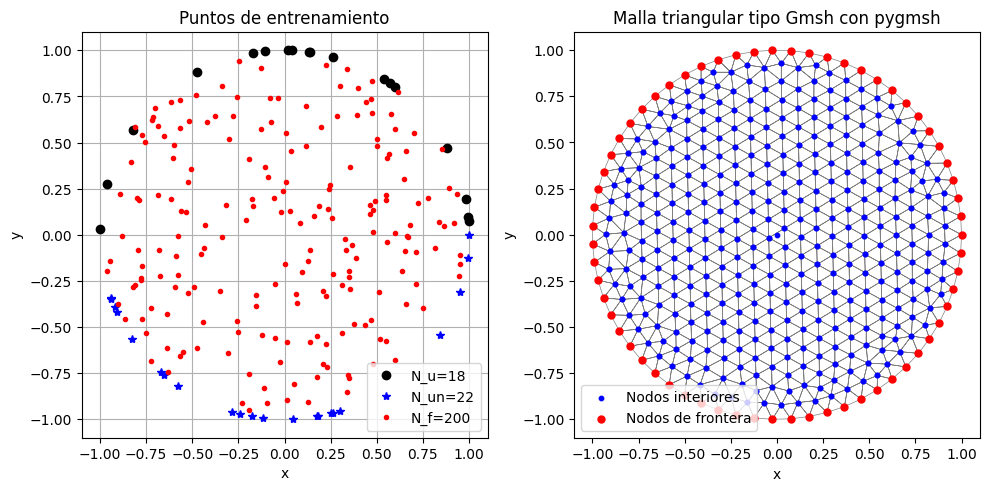

In [45]:
# Subplot 3: Distribución de puntos de entrenamiento
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121)
str1 = f'N_u={N_u}'
str2 = f'N_un={N_un}'
str3 = f'N_f={N_int}'

u_x, u_y = X_u_train[:,0], X_u_train[:,1]
un_x, un_y = X_un_train[:,0], X_un_train[:,1]
xf, yf = X_f_train[:,0], X_f_train[:,1]

ax1.plot(u_x, u_y, 'ok', label=str1) # Dirichlet
ax1.plot(un_x, un_y, '*b', label = str2) # Neumann
ax1.plot(xf, yf, '.r', label=str3) 

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Puntos de entrenamiento')
ax1.set_aspect('equal')
ax1.legend()
ax1.grid(True)

# Subplot 4: Distribución de puntos de prueba

ax2 = fig.add_subplot(122)

ax2.triplot(points[:,0], points[:,1], cells, lw=0.5, color='gray')
ax2.scatter(points[interior_nodes,0], points[interior_nodes,1],
            color='blue', s=10, label='Nodos interiores')
ax2.scatter(points[boundary_nodes,0], points[boundary_nodes,1],
            color='red', s=25, label='Nodos de frontera')
ax2.set_aspect('equal')

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title("Malla triangular tipo Gmsh con pygmsh")
ax2.legend()

plt.tight_layout()
plt.savefig('Act8_grids')
plt.show()

In [7]:
xp.shape

(764,)

Gráficas de la funciones (de frente y atrás)

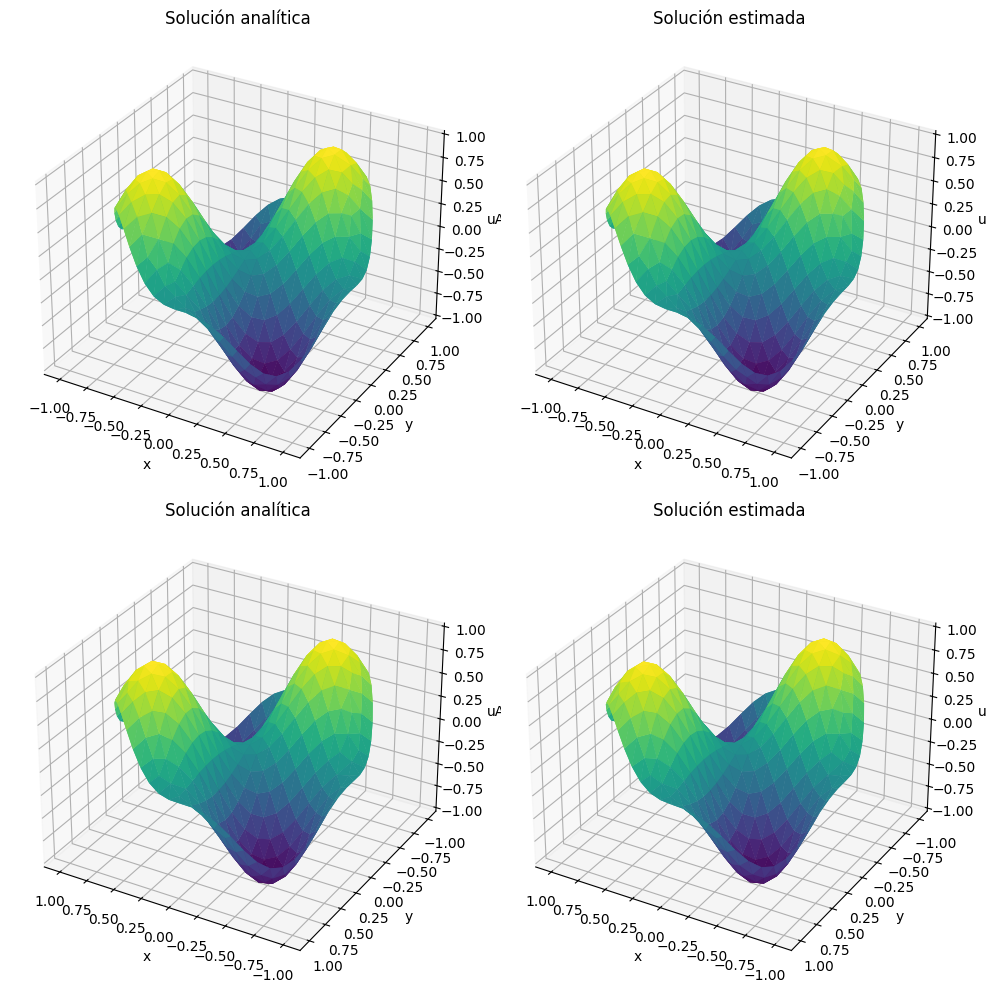

In [47]:
import matplotlib.pyplot as plt                  # Generación de gráficos 2D
from mpl_toolkits.mplot3d import Axes3D          # Gráficos 3D con matplotlib

# .----------------------------------------------.
#  Graficar resultados
# .----------------------------------------------.
#  - Subplot 1: Solución analítica
#  - Subplot 2: Solución predicha
#  - Subplot 3: Distribución de puntos
fig = plt.figure(figsize=(10, 10))

# Subplot 1: Solución analítica de frente
ax1 = fig.add_subplot(221, projection='3d')

ax1.plot_trisurf(xp, yp, up_star, triangles=cells, cmap='viridis', linewidth=0.2, antialiased=True)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('uA')
ax1.set_title('Solución analítica')
ax1.view_init(elev=30, azim=300)

# Subplot 2: Solución estimada por la red de frente
ax2 = fig.add_subplot(222, projection='3d')

ax2.plot_trisurf(xp, yp, up_pred[:,0], triangles=cells, cmap='viridis', linewidth=0.2, antialiased=True)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('uN')
ax2.set_title('Solución estimada')
ax2.view_init(elev=30, azim=300)

# Subplot 1: Solución analítica de atrás
ax3 = fig.add_subplot(223, projection='3d')

ax3.plot_trisurf(xp, yp, up_star, triangles=cells, cmap='viridis', linewidth=0.2, antialiased=True)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('uA')
ax3.set_title('Solución analítica')
ax3.view_init(elev=30, azim=120)

# Subplot 2: Solución estimada por la red de atrás
ax4 = fig.add_subplot(224, projection='3d')

ax4.plot_trisurf(xp, yp, up_pred[:,0], triangles=cells, cmap='viridis', linewidth=0.2, antialiased=True)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('uN')
ax4.set_title('Solución estimada')
ax4.view_init(elev=30, azim=120)

plt.tight_layout()
plt.savefig('Act8_Ex2_Results')
plt.show()

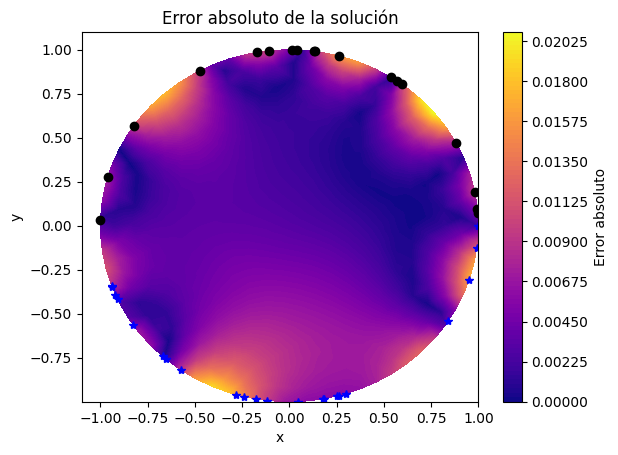

In [48]:
# Subplot 5: Mapa de calor del error
err = np.abs(up_star - up_pred[:,0]) #Error absoluto

# Puntos de la frontera
plt.plot(u_x, u_y, 'ok', label=str1) # Dirichlet
plt.plot(un_x, un_y, '*b', label = str2) # Neumann 

plt.tricontourf(xp, yp, err, levels=100, cmap='plasma')
plt.colorbar(label='Error absoluto')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Error absoluto de la solución')

plt.savefig('Act8_Ex2_heatmap.png')
plt.show()

In [33]:
loss, u_loss, un_loss, f_loss = model.history()

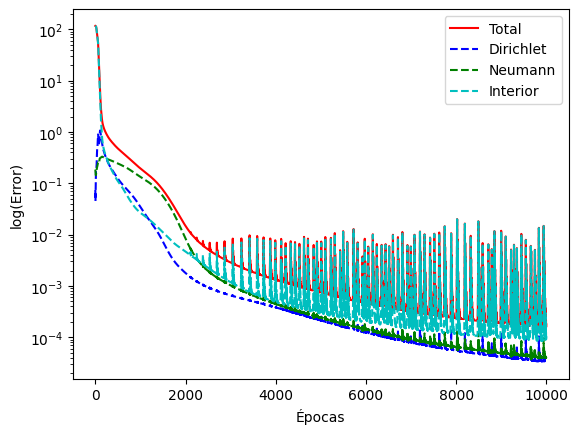

In [51]:
plt.semilogy(range(epochs), loss, 'r', label = 'Total')
plt.semilogy(range(epochs), u_loss, '--b', label = 'Dirichlet')
plt.semilogy(range(epochs), un_loss, '--g', label = 'Neumann')
plt.semilogy(range(epochs), f_loss, '--c', label = 'Interior')

plt.xlabel('Épocas')
plt.ylabel('log(Error)')

plt.legend()
plt.savefig('Act8_Ex2_Epochs.png')
plt.show()